### Training model

In [20]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import shutil

from app_runner import Wrappers

In [36]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)


In [37]:
# x_train as pandas.DataFrame, y_train as pandas.Series
x_train = pd.read_csv(train_file_path)
print(x_train.shape)  # pandas.DataFrame
y_train = x_train.pop("survived")
print(y_train.shape) # pandas.Series


(627, 10)
(627,)


In [38]:
feature_type = {feature: 'numerical' if x_train[feature].dtype in ['int64', 'float64'] else 'categorical' for feature in x_train.columns}
feature_type

{'sex': 'categorical',
 'age': 'numerical',
 'n_siblings_spouses': 'numerical',
 'parch': 'numerical',
 'fare': 'numerical',
 'class': 'categorical',
 'deck': 'categorical',
 'embark_town': 'categorical',
 'alone': 'categorical'}

In [39]:
cls_obj = Wrappers(debug=True)

In [40]:
log_dir = 'logs'
classifier = 'structured_data_classifier'

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

if os.path.exists(classifier):
    shutil.rmtree(classifier)

In [41]:
cls_obj.StructuredDataClassifier(overwrite=True, max_trials=5, column_names = list(x_train.columns), column_types = feature_type, num_classes = 2, tuner="greedy")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
history = cls_obj.sdc_fit(
    x = train_file_path,
    y = "survived",
    evaluation = test_file_path, 
    epochs=10, 
    callbacks=[tensorboard_callback])

INFO:tensorflow:Oracle triggered exit
Epoch 1/10
20/20 [==============================] - 1s 7ms/step - loss: 1.0051 - accuracy: 0.6491
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.8611 - accuracy: 0.6651
Epoch 3/10
20/20 [==============================] - 0s 10ms/step - loss: 0.6483 - accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.8114 - accuracy: 0.6730
Epoch 5/10
20/20 [==============================] - 0s 6ms/step - loss: 0.6309 - accuracy: 0.6858
Epoch 6/10
20/20 [==============================] - 0s 11ms/step - loss: 0.7976 - accuracy: 0.6826
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.6206 - accuracy: 0.7033
Epoch 8/10
20/20 [==============================] - 0s 7ms/step - loss: 0.7502 - accuracy: 0.6970
Epoch 9/10
20/20 [==============================] - 0s 8ms/step - loss: 0.6042 - accuracy: 0.7081
Epoch 10/10
20/20 [==============================] - 0s 8ms/step - loss: 0.718

In [27]:
import pandas as pd
from sklearn.datasets import load_iris


In [28]:
iris = load_iris()
X = iris.data
Y = iris.target


In [29]:
# Create a DataFrame with features and target
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = Y


# Save the DataFrame to a CSV file
file_path = 'iris_dataset.csv'
df.to_csv(file_path, index=False)


In [30]:
x_train = pd.read_csv(file_path)
print(x_train.shape)
y_train = x_train.pop("target")
print(y_train.shape)  # pandas.Series

(150, 5)
(150,)


In [31]:
feature_type = {feature: 'numerical' if x_train[feature].dtype in ['int64', 'float64'] else 'categorical' for feature in x_train.columns}
feature_type

{'sepal length (cm)': 'numerical',
 'sepal width (cm)': 'numerical',
 'petal length (cm)': 'numerical',
 'petal width (cm)': 'numerical'}

In [32]:
cls_obj = Wrappers(debug=True)

In [33]:
import os
train_file_path = os.path.abspath(file_path)
train_file_path

'd:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\iris_dataset.csv'

In [34]:
log_dir = 'logs'
classifier = 'structured_data_classifier'

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

if os.path.exists(classifier):
    shutil.rmtree(classifier)

In [35]:
cls_obj.StructuredDataClassifier(overwrite=True, max_trials=32, column_names = list(x_train.columns), column_types = feature_type, num_classes = 3, tuner="bayesian")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
history = cls_obj.sdc_fit(
    x = train_file_path,
    y = "target",
    evaluation = train_file_path, 
    epochs=2, 
    callbacks=[tensorboard_callback])

INFO:tensorflow:Oracle triggered exit
Epoch 1/2
5/5 [==============================] - 2s 23ms/step - loss: 1.6117 - accuracy: 0.3333
Epoch 2/2
5/5 [==============================] - 0s 18ms/step - loss: 1.5575 - accuracy: 0.3400
INFO:tensorflow:Assets written to: .\structured_data_classifier\best_model\assets
5/5 [==============================] - 0s 4ms/step


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

import autokeras as ak


Using TensorFlow backend


In [6]:
house_dataset = fetch_california_housing()
df = pd.DataFrame(
    np.concatenate(
        (house_dataset.data, house_dataset.target.reshape(-1, 1)), axis=1
    ),
    columns=house_dataset.feature_names + ["Price"],
)
train_size = int(df.shape[0] * 0.9)
df[:train_size].to_csv("train.csv", index=False)
df[train_size:].to_csv("eval.csv", index=False)
train_file_path = "train.csv"
test_file_path = "eval.csv"


In [7]:
# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True, max_trials=3
)  # It tries 3 different models.
# Feed the structured data regressor with training data.
reg.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "Price",
    epochs=10,
)
# Predict with the best model.
predicted_y = reg.predict(test_file_path)
# Evaluate the best model with testing data.
print(reg.evaluate(test_file_path, "Price"))


INFO:tensorflow:Oracle triggered exit
Epoch 1/10
581/581 [==============================] - 2s 2ms/step - loss: 1.2536 - mean_squared_error: 1.2536
Epoch 2/10
581/581 [==============================] - 1s 2ms/step - loss: 0.6403 - mean_squared_error: 0.6403
Epoch 3/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5641 - mean_squared_error: 0.5641
Epoch 4/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5333 - mean_squared_error: 0.5333
Epoch 5/10
581/581 [==============================] - 1s 2ms/step - loss: 0.5155 - mean_squared_error: 0.5155
Epoch 6/10
581/581 [==============================] - 2s 3ms/step - loss: 0.5054 - mean_squared_error: 0.5054
Epoch 7/10
581/581 [==============================] - 1s 2ms/step - loss: 0.4989 - mean_squared_error: 0.4989
Epoch 8/10
581/581 [==============================] - 2s 4ms/step - loss: 0.4930 - mean_squared_error: 0.4930
Epoch 9/10
581/581 [==============================] - 2s 3ms/step - loss: 0.4875 -

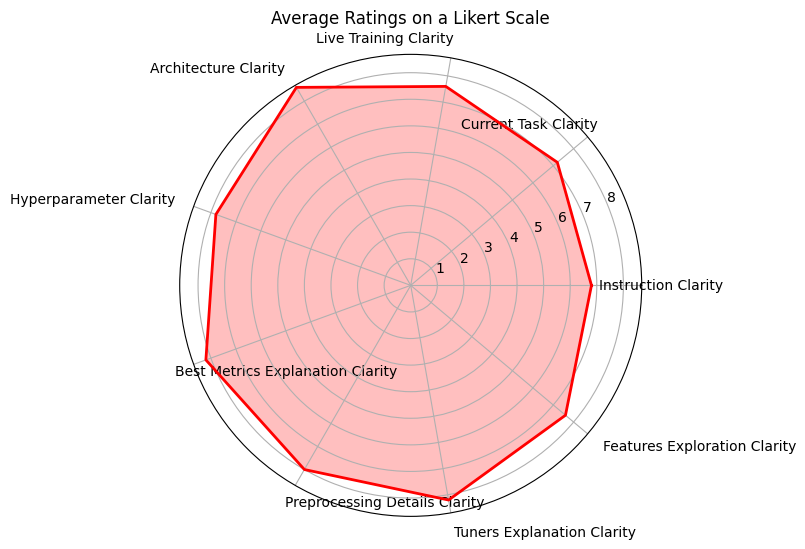

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Since the data is in an image, we will input the data manually
# Data input in the format of a dictionary where the key is the question and the value is the list of responses
data = {
    "Instruction Clarity": [7, 7, 7, 6, 7],
    "Current Task Clarity ": [7, 7, 8, 6, 8],
    "Live Training Clarity": [8, 7, 7, 8, 8],
    "Architecture Clarity": [9, 9, 8, 9, 8],
    "Hyperparameter Clarity": [7, 8, 8, 8, 8],
    "Best Metrics Explanation Clarity": [9, 8, 7, 9, 8],
    "Preprocessing Details Clarity": [9, 8, 7, 8, 8],
    "Tuners Explanation Clarity": [8, 8, 9, 8, 8],
    "Features Exploration Clarity": [8, 7, 7, 8, 8]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Calculate the mean of each column to get the average rating for each question
averages = df.mean()

# Create a radar chart
labels = np.array(averages.index)
stats = averages.values

# Create a 360 degree angle array
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# The plot is made circular by appending the first value to the end
stats = np.concatenate((stats, [stats[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, color='red', linewidth=2)  # Change the color if you like

# Set the category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Use the tag below to rotate the labels if they overlap or are not easily readable
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

plt.title('Average Ratings on a Likert Scale')
plt.show()


In [14]:
data = {}

In [15]:
import os
import autokeras as ak
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from alibi.explainers import ALE, plot_ale
from alibi.explainers import CounterFactual

class Features:

    def __init__(self, project_name : 'str', train_file_path: 'str'):
        self.project_name = project_name
        self.train_file_path = train_file_path

        current_directory = "D:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\"
        # current_directory = os.path.dirname(os.path.abspath(__file__))
        model_directory = os.path.dirname(current_directory)
        best_model_path = os.path.join(model_directory, self.project_name, 'best_model')
        
        self.get_model(best_model_path)


    def get_model(self, best_model_path):
        model = load_model(best_model_path, custom_objects=ak.CUSTOM_OBJECTS)
        self.model = model
        index = self.seperate_model_index(model) 
        self.preprocessing_model = Model(inputs=model.input, outputs=model.layers[index].output)
        self.dense_model = Model(inputs=model.layers[index+1].input, outputs=model.output) 

    def seperate_model_index(self, model):
        layer_names = [layer.name for layer in model.layers]
        for index, name in enumerate(layer_names):
            if 'dense' in name:
                return index - 1

    def generate_counterfactuals(self):

        self.x_train = pd.read_csv(self.train_file_path)
        self.target_name = "target"

        x_train = self.x_train.drop([self.target_name], axis=1)
        input_data = np.array(x_train.iloc[:,:]).tolist()


        self.output = self.preprocessing_model.predict(input_data)
        # Initialize Counterfactual explainer
        cf = CounterFactual(self.dense_model, shape=self.output.shape, target_proba=1.0, tol=0.01, max_iter=1000)

        # Generate explanation
        explanation = cf.explain(self.output)

        # You can add additional code to process the explanation and extract useful information
        return explanation



In [16]:
feat = None

In [17]:
if hasattr(feat, 'project_name'):
    print("already initailized")
else:
    feat = Features("structured_data_classifier", 'd:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\iris_dataset.csv')

In [48]:
feat.x_train

AttributeError: 'Features' object has no attribute 'x_train'

In [19]:
fop = feat.dense_model.predict(feat.output)
fop.shape

1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


(150, 3)

In [20]:
fop

array([[0.47515303, 0.22109282, 0.30375415],
       [0.4136951 , 0.26960486, 0.31670004],
       [0.4251287 , 0.2579564 , 0.31691495],
       [0.40422094, 0.27656952, 0.31920955],
       [0.48243967, 0.21190901, 0.30565128],
       [0.4896686 , 0.19428574, 0.3160456 ],
       [0.44409   , 0.23360057, 0.32230937],
       [0.4553418 , 0.23493078, 0.30972746],
       [0.3785106 , 0.29419807, 0.3272913 ],
       [0.42989948, 0.25931197, 0.31078848],
       [0.50585955, 0.2014758 , 0.2926647 ],
       [0.45190853, 0.23642404, 0.3116674 ],
       [0.41867983, 0.26673013, 0.31459004],
       [0.39396036, 0.2819574 , 0.32408226],
       [0.5381586 , 0.17118178, 0.29065958],
       [0.44611436, 0.15395452, 0.39993107],
       [0.50386965, 0.18411276, 0.31201765],
       [0.47075573, 0.22197162, 0.3072727 ],
       [0.5070353 , 0.19843082, 0.29453388],
       [0.49735823, 0.19801089, 0.3046309 ],
       [0.45891398, 0.23735265, 0.30373335],
       [0.4834168 , 0.20784569, 0.30873758],
       [0.

In [21]:
flatten = lambda l: [item for sublist in l for item in sublist]
        

predictions = np.argmax(fop,axis=1)
predictions = predictions.tolist()
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [18]:
feat.generate_counterfactuals()

5/5 [==============================] - 0s 4ms/step


c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\alibi\explainers\counterfactual.py:71: FutureWarning:

The class name `CounterFactual` is deprecated, please use `Counterfactual`.




5/5 [==============================] - 0s 3ms/step


RuntimeError: tf.placeholder() is not compatible with eager execution.

In [30]:
feat.plot_integrated_gradients(4)

1/1 [==============================] - 0s 262ms/step
[[-1.1430168  -0.13197926 -1.3402265  -1.3154445 ]
 [-1.385353    0.32841444 -1.397064   -1.3154445 ]
 [-1.5065207   0.09821732 -1.2833891  -1.3154445 ]]


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [14]:
x_train = pd.read_csv(feat.train_file_path)


x_train = x_train.drop(["tag"], axis=1)

input_data = np.array(x_train.iloc[:,:]).tolist()

output = feat.preprocessing_model.predict(input_data)

20/20 [==============================] - 0s 5ms/step


In [84]:
x_train_og = pd.read_csv(feat.train_file_path)

In [45]:
output = feat.preprocessing_model.predict(np.array(x_train.iloc[:,:]).tolist())

20/20 [==============================] - 0s 4ms/step


In [76]:
output[0].shape

(9,)

In [95]:
test = output[0].reshape(1,-1)

In [96]:
test.shape

(1, 9)

In [98]:
test[0]

array([-0.7275079 , -0.610415  ,  0.395198  , -0.4790527 , -0.49740276,
       -0.82992667, -0.45484465, -0.57665044,  1.2078174 ], dtype=float32)

In [89]:
x = np.array([[9.2, 0.36, 0.34, 1.6, 0.062, 5., 12., 0.99667, 3.2]]) 

In [112]:
np.array(x_train.iloc[0:3])

array([['male', 22.0, 1, 0, 7.25, 'Third', 'unknown', 'Southampton', 'n'],
       ['female', 38.0, 1, 0, 71.2833, 'First', 'C', 'Cherbourg', 'n'],
       ['female', 26.0, 0, 0, 7.925, 'Third', 'unknown', 'Southampton',
        'y']], dtype=object)

In [113]:
output[0:3]

array([[-0.7275079 , -0.610415  ,  0.395198  , -0.4790527 , -0.49740276,
        -0.82992667, -0.45484465, -0.57665044,  1.2078174 ],
       [ 1.3745551 ,  0.6693971 ,  0.395198  , -0.4790527 ,  0.6763534 ,
         0.43003452,  0.27082357,  0.98179793,  1.2078174 ],
       [ 1.3745551 , -0.29046196, -0.47423774, -0.4790527 , -0.48502973,
        -0.82992667, -0.45484465, -0.57665044, -0.8279398 ]],
      dtype=float32)

In [118]:
from alibi.explainers import AnchorTabular

def pred(x):
    predictions = feat.dense_model.predict(x)
    return predictions
explainer = AnchorTabular(pred, x_train.columns)
explainer.fit(output)

# x is the instance to explainnp.array(x_train.iloc[0].tolist())
result = explainer.explain(output[1])

print('Anchor =', result.data['anchor'])
print('Coverage = ', result.data['coverage'])

1/1 [==============================] - 0s 78ms/step


4/4 [==============================] - 0s 4ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [79]:
pred(test)

1/1 [==============================] - 0s 80ms/step


array([[0.13970675]], dtype=float32)

In [204]:
a = feat.model(np.array(input_data))


In [370]:
def predict_fn(x):
    predictions = feat.model.predict(x)
    return predictions

In [371]:
from alibi.explainers import PermutationImportance, plot_permutation_importance

In [372]:
explainer = PermutationImportance(predictor=predict_fn,
                                  score_fns=['accuracy', 'f1'],
                                  feature_names=x_train.columns,
                                  verbose=True)

In [373]:
X_test  = pd.read_csv(feat.train_file_path)
y_test = X_test["survived"]
X_test = X_test.drop(["survived"], axis=1)
exp = explainer.explain(X=X_test, y=y_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
plot_permutation_importance(exp,
                            n_cols=2,
                            fig_kw={'figwidth': 14, 'figheight': 6})

In [50]:
from causalnex.structure import StructureModel
import matplotlib.pyplot as plt
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import json

# Create a causal structure model
sm = StructureModel()

# # Add nodes and edges
sm.add_edges_from([
    ('Start Trial', 'Populate the Search Space'),
    ('Populate the Search Space', 'Not Enough Points (read description)'),
    ('Not Enough Points (read description)', 'Select Random Values for Hyperparameters'),
    ('Select Random Values for Hyperparameters', 'End Trial')
])

instruction= [{"id":"Step1", "label": "Start_trial"}, {"id":"Step2", "label": "End_trial"}]
    

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

all_node_attributes = {
    "font": {
        "color": "#FFFFFFD9",
        "face": "Helvetica",
        "size": 20,
    },
    "shape": "box",
    "size": 20,
    "borderWidth": 1,
    "color": {
        "border": "#4a90e2d9",
        "background": "black"
    },
    "mass": 3
}


all_edge_attributes = {
    "color":{
        "color": "#FF4433",
    },
    "length": 20,
}

viz = plot_structure(
sm,
all_node_attributes=all_node_attributes,
all_edge_attributes=all_edge_attributes,
)

opt = {
    "layout":
        {
            "hierarchical": {
                "enabled": True,
                "direction": "UD", #UD means that the hierarchy is displayed up to down
            }
        },
        "physics": {
       "solver": "repulsion",
       "repulsion": {
           "nodeDistance": 200,
           "springLength": 50,
           "springConstant": 0.5
       }
   }
}

viz.set_options(options=json.dumps(opt))


viz.save_graph("try_bayesian.html")

In [52]:
import plotly.graph_objects as go
import numpy as np

# Provided mu and sigma values
mu_values = [
    -0.6289298559752646, -0.5528523604900735, -0.7248425559912455, -0.6613375669914794, 
    -0.6399825003117323, -0.5666667770560831, -0.5044758219096488, -0.6526573754039428, 
    -0.7166286730842583, -0.5755708301087518, -0.5660336427379783, -0.6797438169438212, 
    -0.6317953307104082, -0.7102346985721661, -0.6230999303735769, -0.5847374314333005, 
    -0.5975220154449082, -0.6996186263536348, -0.5955056276587527, -0.6805980342497956, 
    -0.578568751752372, -0.7003255309724562, -0.6586369090814683, -0.6414740297197631, 
    -0.5688738735580293, -0.6549411961653645, -0.6530342714120142, -0.5734468950968958, 
    -0.5696300183860109, -0.5985895294450252, -0.5168317545033794, -0.4982716053464082, 
    -0.5744696611421952, -0.6414819405732443, -0.5420747468938864, -0.5085739550751293, 
    -0.6021789110866586, -0.5937156313433187, -0.630154555351567, -0.6263155441881771, 
    -0.6027144184133979, -0.7326344537333916, -0.635270587600564, -0.6918509251387995, 
    -0.629156796132121, -0.5881986417659179, -0.5931606996721237, -0.6260207179704183, 
    -0.5894982608452919, -0.5968540159272233
]
sigma_values = [
    0.15735321699180657, 0.14700134493959122, 0.1453556682731306, 0.16387056652871984, 
    0.15250869536285103, 0.1627352568407832, 0.14537804054797487, 0.13000927528687858, 
    0.16117256271197744, 0.16337844526051323, 0.13543313441906432, 0.16060092696191774, 
    0.1586791778268671, 0.15444463292371746, 0.15596554109127925, 0.15934621657966122, 
    0.14086176513658993, 0.14724796527707554, 0.15849948739006348, 0.15549858048973333, 
    0.14700879727130733, 0.1454873354531344, 0.13265601395904092, 0.1645010406902345, 
    0.16208145038209545, 0.16174988073407282, 0.1411628237384001, 0.16177730818832967, 
    0.16064139448049064, 0.13283261580526728, 0.1596798664224313, 0.14195276322908235, 
    0.16116366822398498, 0.15763170000072751, 0.1567010985339625, 0.14632379290251005, 
    0.1394057586853594, 0.14994855578205815, 0.16056399876386843, 0.16592243274899396, 
    0.15804233345019858, 0.13959849549372644, 0.1419517759408441, 0.15719774127433186, 
    0.16263729387516457, 0.16360835363038564, 0.16130320918961225, 0.15364940836551347, 
    0.1601741936408748, 0.16610994795031447
]

# Convert to numpy arrays for easier manipulation
mu_values = np.array(mu_values)
sigma_values = np.array(sigma_values)

# Generating X values (assuming these are sequential for the purpose of the plot)
x_values = np.arange(len(mu_values))

# Creating the plot
fig = go.Figure([
    go.Scatter(
        name='Mean',
        x=x_values,
        y=mu_values,
        mode='lines',
        line=dict(color='blue'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=x_values,
        y=mu_values + 2 * sigma_values,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=x_values,
        y=mu_values - 2 * sigma_values,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])

fig.update_layout(
    title='Gaussian Process Regression: Mean and Confidence Intervals',
    xaxis_title='X',
    yaxis_title='Y',
    hovermode="x unified"
)

fig.show()


In [ ]:
def addGraph(data):
    not_enough_info = data.get('enough_points',False)
    if not_enough_info:
        return {'Not Enough info, doing random search'}
    else:
        
        


In [9]:
import json 
with open("structured_data_classifier\decision_factors_1699702255250.json", "r") as f:
    data = json.load(f)

data['casulnex_graph'] = addGraph(data)
    

{'tuner': 'bayesian',
 'trial_id': '00',
 'num_initial_points': 27,
 'enough_points': [False, 'Using Random Values']}

In [14]:
df = pd.read_csv(train_file_path)


In [26]:
import pandas as pd
import plotly.express as px

# Load the Titanic dataset into a pandas DataFrame
# Replace 'your_dataset.csv' with your dataset file name


# Create separate histograms for each column
for column in df.columns:
    fig = px.histogram(df, x=column, title=f'Data Distribution of {column}')
    fig.update_layout(height=400, width=400)
    fig.show()


In [61]:
import plotly.graph_objects as go

# Define the positions of the rectangles
positions = [0, 0.5, 1]

# Create figure
fig = go.Figure()

# Define the layout of the rectangles
rect_width = 0.15  # Reduce the width of the rectangles
rect_height = 0.15

# Add rectangles to the plot
for pos in positions:
    fig.add_shape(
        type="rect",
        x0=pos - (rect_width / 2),
        y0=0,
        x1=pos + (rect_width / 2),
        y1=rect_height,
        line=dict(color="blue", width=2),
    )

# Add arrows to connect the rectangles
for i in range(len(positions) - 1):
    start_x = positions[i + 1] - (rect_width / 2)  
    end_x = positions[i] + (rect_width / 2)
    fig.add_annotation(
        x=start_x,
        y=rect_height / 2,
        ax=end_x,
        ay=rect_height / 2,
        xref="x",
        yref="y",
        axref="x",
        ayref="y",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="black"
    )

# Update layout to remove the background and adjust plot size
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
    margin=dict(l=0, r=0, t=0, b=0),  # Set margin to 0 for minimal space
    height=150,  # Set the height of the plot
)

# Show the figure
fig.show()


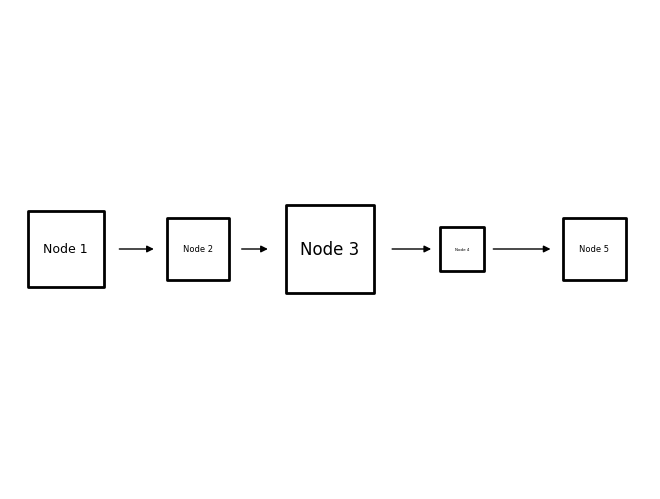

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a graph with a specified number of nodes and variable sizes
def create_graph_with_variable_sizes(node_sizes):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with text inside them
    nodes_with_text = {i: f'Node {i}' for i in range(1, len(node_sizes) + 1)}

    for node, text in nodes_with_text.items():
        G.add_node(node, label=text)

    # Define positions for the nodes horizontally
    pos = {node: (node, 0) for node in range(1, len(node_sizes) + 1)}

    # Add edges between the nodes
    edges = [(i, i + 1) for i in range(1, len(node_sizes)) if i + 1 <= len(node_sizes)]

    G.add_edges_from(edges)

    # Draw the graph
    labels = {node: data['label'] for node, data in G.nodes(data=True) if node in node_sizes}

    # Adjust the node sizes and text sizes dynamically
    node_sizes_values = [node_sizes[node] * 1000 for node in node_sizes]
    text_sizes = [node_sizes[node] * 3 for node in node_sizes]

    node_color = 'white'
    border_color = 'black'

    nx.draw(G, pos, with_labels=False, node_size=node_sizes_values, node_shape='s', node_color=node_color,
            edgecolors=border_color, linewidths=2)

    # Add node labels with adjusted text sizes
    for node, label in labels.items():
        plt.text(pos[node][0], pos[node][1], label, fontsize=text_sizes[node - 1], ha='center', va='center', color='black')

    # Add text over the arrows
    edge_labels = {(i, i + 1): f'Arrow {i}->{i + 1}' for i in range(1, len(node_sizes)) if i + 1 <= len(node_sizes)}

    # Adjust the edge label font size dynamically based on the node sizes
    edge_label_sizes = {(i, i + 1): node_sizes[i] * 2 for i in range(1, len(node_sizes)) if i + 1 <= len(node_sizes)}

    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=)

    plt.axis('off')
    plt.show()

# Example: Create a graph with 5 nodes and different sizes for each node
node_sizes = {1: 3, 2: 2, 3: 4, 4: 1, 5: 2}
create_graph_with_variable_sizes(node_sizes)


In [28]:
values

{'structured_data_block_1/normalize': True,
 'structured_data_block_1/dense_block_1/num_layers': 2,
 'structured_data_block_1/dense_block_1/use_batchnorm': False,
 'structured_data_block_1/dense_block_1/dropout': 0,
 'structured_data_block_1/dense_block_1/units_0': 32,
 'structured_data_block_1/dense_block_1/units_1': 32,
 'classification_head_1/dropout': 0.0,
 'optimizer': 'adam',
 'learning_rate': 0.001}

In [2]:
import autokeras as ak

# Initialize the AutoModel
model = ak.AutoModel(
    inputs=ak.StructuredDataInput(),
    outputs=ak.ClassificationHead(),
    max_trials=1  # Number of different Keras Models to try
)

# Build the model to view its architecture
model = model.build()

# Display a summary of the model architecture
model.summary()

Using TensorFlow backend


AttributeError: 'AutoModel' object has no attribute 'build'

C:\Users\Deepanshu\AppData\Local\Temp\ipykernel_16348\2149529411.py:30: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



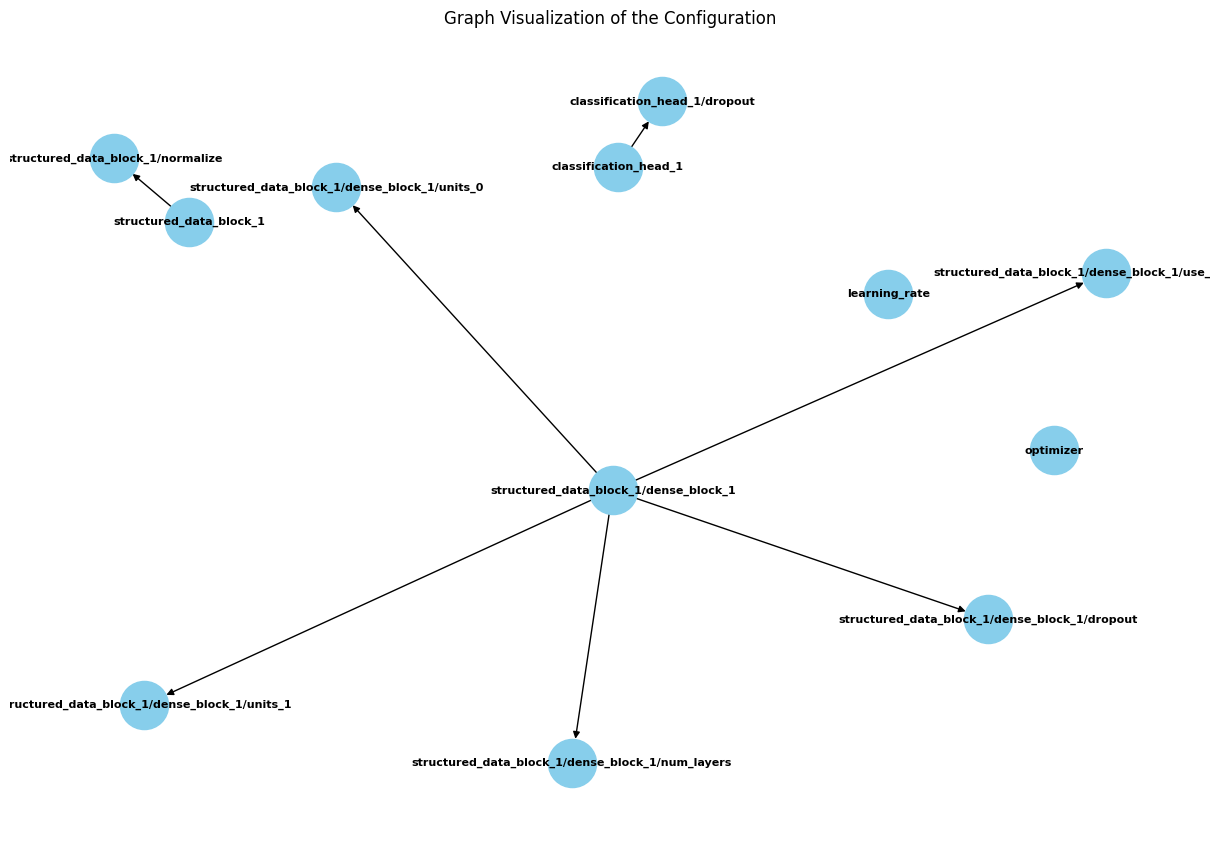

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

data = {
    "structured_data_block_1/normalize": True,
    "structured_data_block_1/dense_block_1/num_layers": 2,
    "structured_data_block_1/dense_block_1/use_batchnorm": False,
    "structured_data_block_1/dense_block_1/dropout": 0,
    "structured_data_block_1/dense_block_1/units_0": 32,
    "structured_data_block_1/dense_block_1/units_1": 32,
    "classification_head_1/dropout": 0,
    "optimizer": "adam",
    "learning_rate": 0.001
}

G = nx.DiGraph()

for key, value in data.items():
    G.add_node(key, label=f"{key}\n{value}")

for key, value in data.items():
    if '/' in key:
        parent, child = key.rsplit('/', 1)
        G.add_edge(parent, key)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Choose layout, 'spring_layout' used here
nx.draw(G, pos, with_labels=True, node_size=1200, node_color='skyblue', font_weight='bold', font_size=8)
plt.title("Graph Visualization of the Configuration")
plt.tight_layout()
plt.savefig('graph_networkx.png', format="PNG")
plt.show()


In [10]:
import plotly.express as px
import pandas as pd

# Load your Titanic dataset into a pandas DataFrame
# Replace this with your actual Titanic dataset
# For example, assuming 'df' is your DataFrame containing the Titanic dataset

# Sample DataFrame (you can replace this with your actual dataset)
data = {
    'Survived': [0, 1, 1, 1, 0],
    'Pclass': [3, 1, 3, 1, 3],
    'Name': ['Mr. A', 'Mrs. B', 'Miss C', 'Mrs. D', 'Mr. E'],
    'Sex': ['male', 'female', 'female', 'female', 'male'],
    'Age': [22, 38, 26, 35, 35],
    'Fare': [7.25, 71.28, 7.92, 53.1, 8.05]
}
df = pd.DataFrame(data)

# Create histograms for numerical columns (Age, Fare)
fig = px.histogram(df, x='Age', title='Distribution of Age in Titanic Dataset')
fig.show()

fig = px.histogram(df, x='Fare', title='Distribution of Fare in Titanic Dataset')
fig.show()


In [8]:
from ipycytoscape import CytoscapeWidget

# Sample flowchart data
flowchart_elements = [
    {'data': {'id': 'start', 'label': 'Start'}},
    {'data': {'id': 'step1', 'label': 'Step 1'}},
    {'data': {'id': 'step2', 'label': 'Step 2'}},
    {'data': {'id': 'end', 'label': 'End'}},
    {'data': {'source': 'start', 'target': 'step1'}},
    {'data': {'source': 'step1', 'target': 'step2'}},
    {'data': {'source': 'step2', 'target': 'end'}},
    {'data': {'source': 'end', 'target': 'start'}}  # Optional loop back to the start
]

# Create a Cytoscape widget and set elements
cytoscape = CytoscapeWidget()
cytoscape.graph.add_graph_from_json(flowchart_elements)

# Set layout options (optional)
cytoscape.set_layout(name='dagre', animate=False)

# Show the flowchart
cytoscape


TypeError: list indices must be integers or slices, not str

In [20]:
import networkx as nx
import json

# Create a directed graph representing the flowchart
flowchart = nx.DiGraph()

# Adding nodes to the flowchart with 'x' and 'y' attributes
positions = {
    "Start": {"x": 50, "y": 50},
    "Step 1": {"x": 150, "y": 50},
    "Step 2": {"x": 250, "y": 50},
    "End": {"x": 350, "y": 50}
}

for node, pos in positions.items():
    flowchart.add_node(node, x=pos["x"], y=pos["y"], label=node)

# Adding edges to represent the flow
flowchart.add_edge("Start", "Step 1")
flowchart.add_edge("Step 1", "Step 2")
flowchart.add_edge("Step 2", "End")
flowchart.add_edge("End", "Start")  # Optional loop back to the start

# Convert the graph to a format that can be serialized (e.g., JSON)
flowchart_data = nx.node_link_data(flowchart)

# Serialize the flowchart data to a JSON file
with open('flowchart.json', 'w') as file:
    json.dump(flowchart_data, file)


In [19]:
from ipycytoscape import CytoscapeWidget

# Load the saved flowchart data from the JSON file
with open('flowchart.json', 'r') as file:
    flowchart_data = json.load(file)

# Create a Cytoscape widget and set elements from the flowchart data
cytoscape_flowchart = CytoscapeWidget()
cytoscape_flowchart.graph.add_graph_from_json(flowchart_data)

# Set layout options (optional)
cytoscape_flowchart.set_layout(name='dagre', animate=True)

# Display the flowchart
cytoscape_flowchart


CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'animate': True}, cytoscape_style=[{'selector': 'node', 'cs…

c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


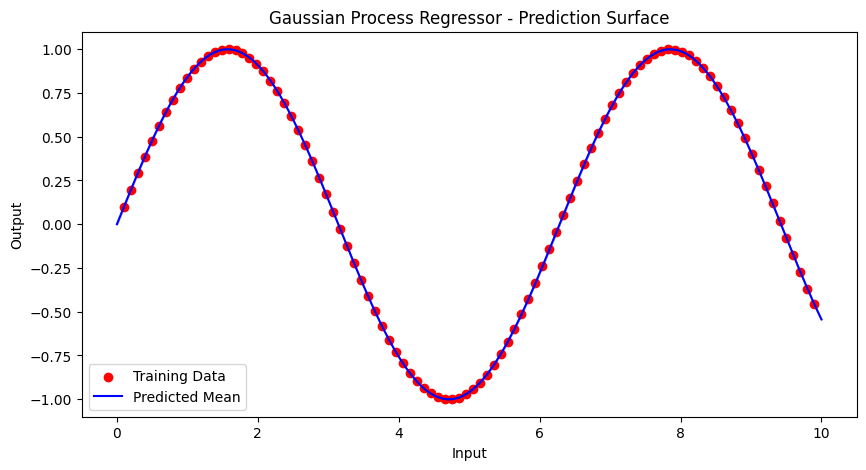

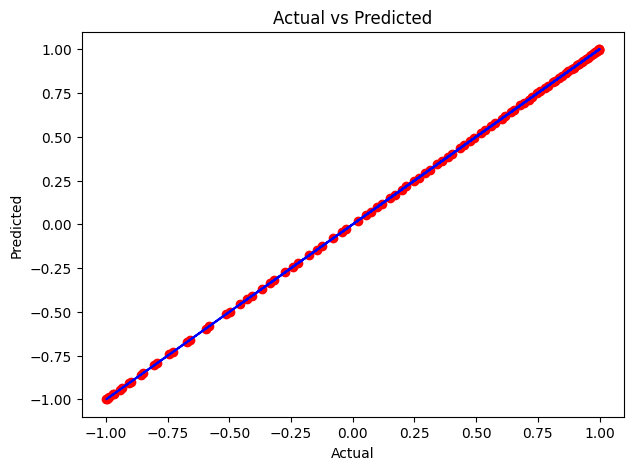

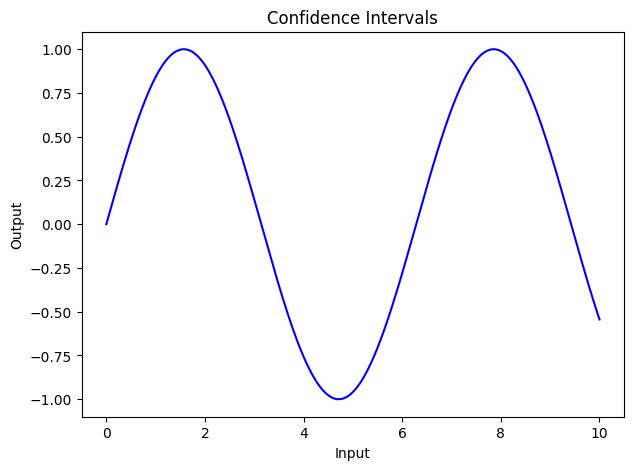

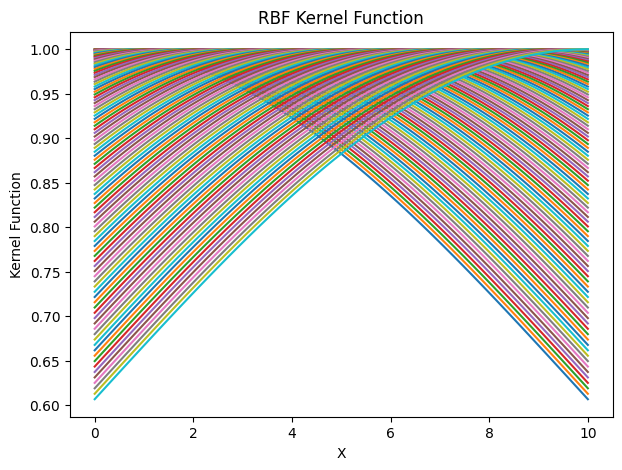

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

# Create synthetic data
np.random.seed(0)
X = np.linspace(0.1, 9.9, 100).reshape(-1, 1)
y = np.sin(X).ravel()

# Fit the GPR
kernel = C(1.0, (1e-3, 1e3)) * RBF(10.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpr.fit(X, y)

# Predictions
x_pred = np.linspace(0, 10, 1000)[:, np.newaxis]
y_pred, sigma = gpr.predict(x_pred, return_std=True)

# Visualization 1: Prediction Surface Plot
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='red', label='Training Data')
plt.plot(x_pred, y_pred, label='Predicted Mean', color='blue')
plt.fill_between(x_pred[:, 0], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.3, color='blue')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regressor - Prediction Surface')
plt.legend()
plt.show()

# Visualization 2: Actual vs Predicted Plot
plt.figure(figsize=(7, 5))
plt.scatter(y, gpr.predict(X), color='red')
plt.plot(y, y, color='blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Visualization 3: Confidence Intervals
plt.figure(figsize=(7, 5))
plt.fill_between(x_pred[:, 0], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.3)
plt.plot(x_pred, y_pred, color='blue')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Confidence Intervals')
plt.show()

# Visualization 4: Kernel Plot (Single Kernel)
x_kernel = np.linspace(0, 10, 100)
plt.figure(figsize=(7, 5))
plt.plot(x_kernel, kernel(x_kernel.reshape(-1, 1)))
plt.xlabel('X')
plt.ylabel('Kernel Function')
plt.title('RBF Kernel Function')
plt.show()


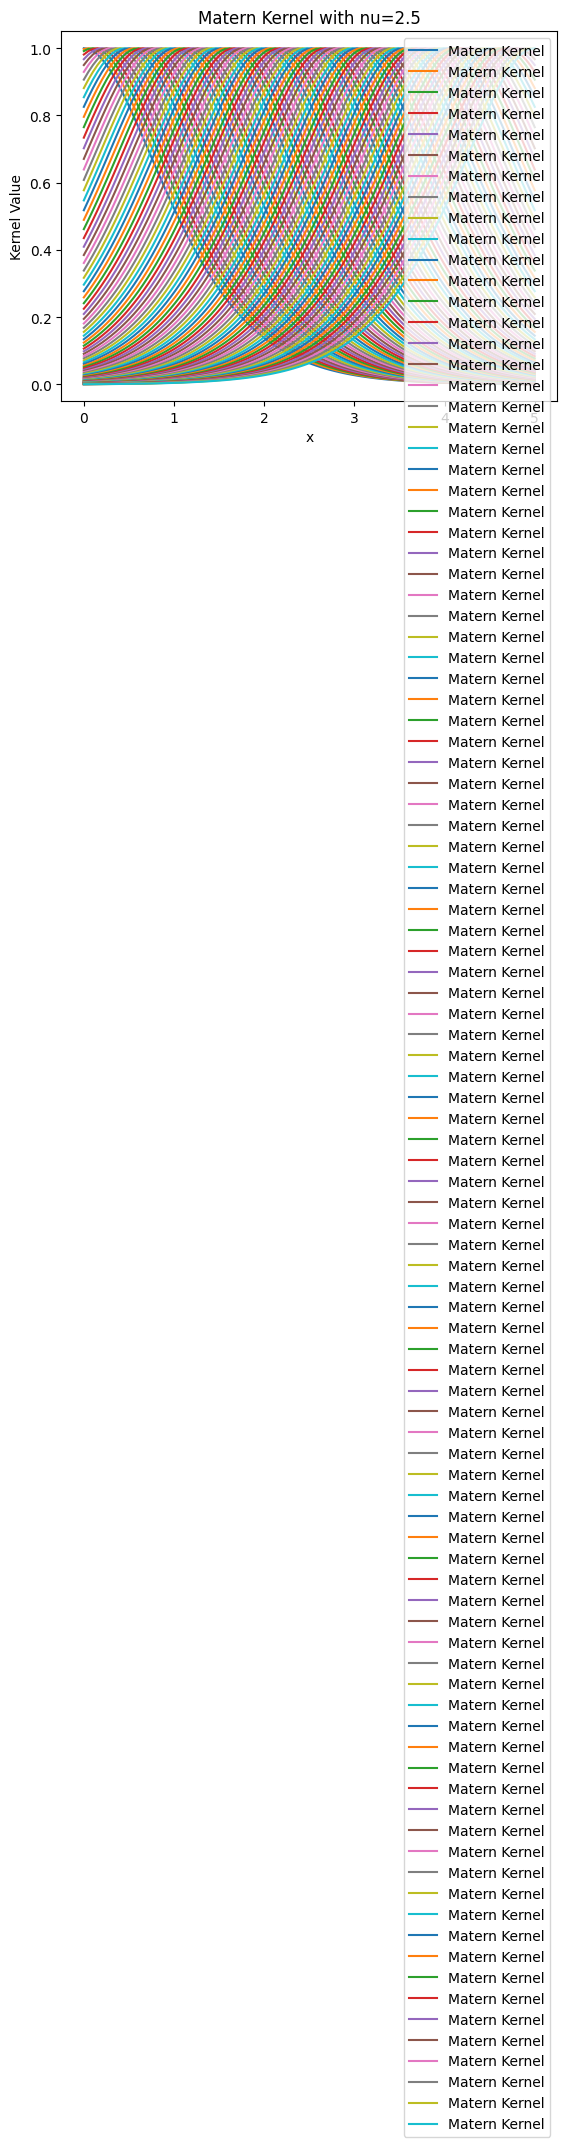

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern

x = np.linspace(0, 5, 100)
kernel = Matern(length_scale=1.0, nu=2.5)

# Compute the kernel values
K = kernel(np.expand_dims(x, 1))

plt.plot(x, K, label='Matern Kernel')
plt.xlabel('x')
plt.ylabel('Kernel Value')
plt.title('Matern Kernel with nu=2.5')
plt.legend()
plt.show()


In [11]:
import json
json_file_path = "structured_data_classifier/decision_factors_1698257995198.json"
try:
    # Open the JSON file for reading
    with open(json_file_path, "r") as json_file:
        # Load the JSON data from the file
        data = json.load(json_file)

    # Now 'data' contains the contents of the JSON file
    print(data)

except FileNotFoundError:
    print(f"File not found: {json_file_path}")

except json.JSONDecodeError as e:
    print(f"JSON decoding error: {e}")


{'trial_id': '1', 'trie_json': {'num_leaves': 9, 'hp_name': None, 'children': {'structured_data_block_1': {'num_leaves': 6, 'hp_name': None, 'children': {'normalize': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/normalize', 'children': {}}, 'dense_block_1': {'num_leaves': 5, 'hp_name': None, 'children': {'use_batchnorm': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/use_batchnorm', 'children': {}}, 'num_layers': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/num_layers', 'children': {}}, 'units_0': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/units_0', 'children': {}}, 'dropout': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/dropout', 'children': {}}, 'units_1': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/units_1', 'children': {}}}}}}, 'classification_head_1': {'num_leaves': 1, 'hp_name': None, 'children': {'dropout': {'num_leaves': 1, 'hp_name': 'classification_head

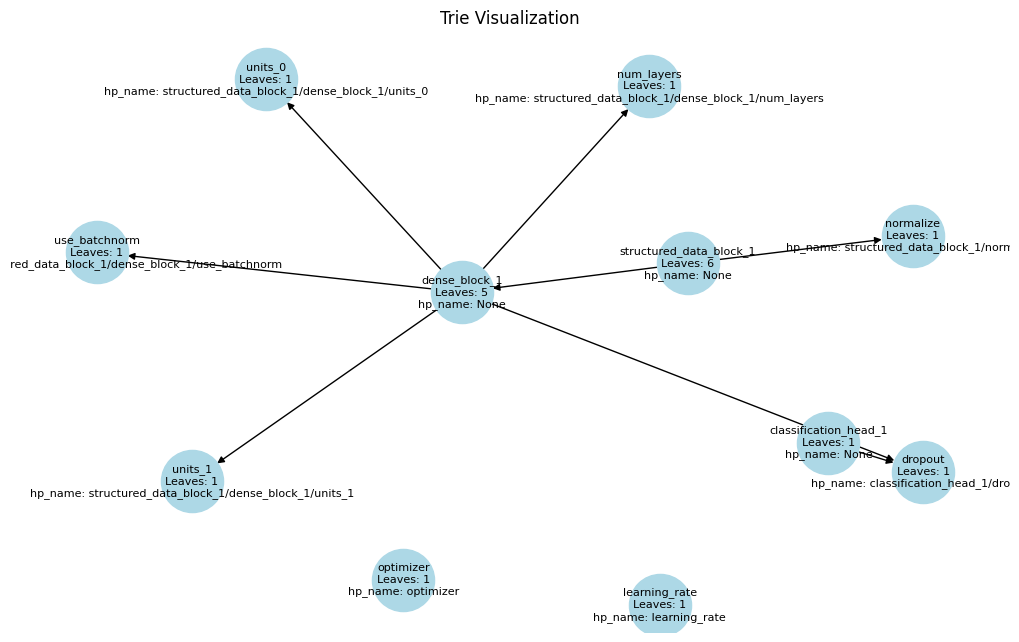

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Load the Trie JSON data from the file
json_file_path = "structured_data_classifier\decision_factors_1698257995198.json"

try:
    with open(json_file_path, "r") as json_file:
        trie_data = json.load(json_file)['trie_json']

    # Function to add nodes and edges to the graph
    def add_nodes(graph, node_data, parent=None):
        for key, value in node_data['children'].items():
            graph.add_node(key, num_leaves=value['num_leaves'], hp_name=value['hp_name'])
            if parent is not None:
                graph.add_edge(parent, key)
            add_nodes(graph, value, key)

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    add_nodes(G, trie_data)

    # Define node positions (this is optional but can help layout the tree)
    pos = nx.spring_layout(G, seed=42)

    # Draw the tree
    plt.figure(figsize=(10, 6))
    labels = {node: f"{node}\nLeaves: {data['num_leaves']}\nhp_name: {data['hp_name']}" for node, data in G.nodes(data=True)}
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color="lightblue", font_size=8, font_color="black")
    plt.title("Trie Visualization")
    plt.show()

except FileNotFoundError:
    print(f"File not found: {json_file_path}")

except json.JSONDecodeError as e:
    print(f"JSON decoding error: {e}")


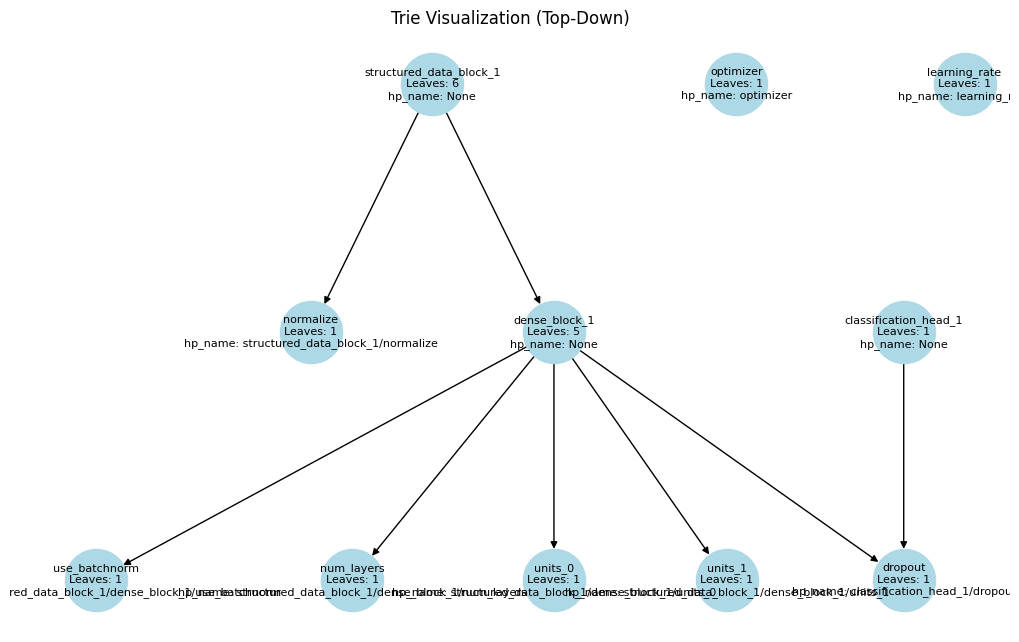

In [10]:
import json
import networkx as nx
import matplotlib.pyplot as plt

# Path to your Trie JSON file
json_file_path = "structured_data_classifier/decision_factors_1698258010733.json"

try:
    # Load the Trie JSON data from the file
    with open(json_file_path, "r") as json_file:
        trie_data = json.load(json_file)['trie_json']

    # Function to add nodes and edges to the graph
    def add_nodes(graph, node_data, parent=None):
        for key, value in node_data['children'].items():
            graph.add_node(key, num_leaves=value['num_leaves'], hp_name=value['hp_name'])
            if parent is not None:
                graph.add_edge(parent, key)
            add_nodes(graph, value, key)

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    add_nodes(G, trie_data)

    # Define a custom layout with a top-down orientation
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB")

    # Draw the tree
    plt.figure(figsize=(10, 6))
    labels = {node: f"{node}\nLeaves: {data['num_leaves']}\nhp_name: {data['hp_name']}" for node, data in G.nodes(data=True)}
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, node_color="lightblue", font_size=8, font_color="black")
    plt.title("Trie Visualization (Top-Down)")
    plt.show()

except FileNotFoundError:
    print(f"File not found: {json_file_path}")

except json.JSONDecodeError as e:
    print(f"JSON decoding error: {e}")


In [43]:
json_file_path = "structured_data_classifier/decision_factors_1698258010733.json"
with open(json_file_path, "r") as json_file:
    data = json.load(json_file)
    trie_data = data["trie_json"]

In [44]:
data["hp_names"][0]

'structured_data_block_1/dense_block_1/units_0'

In [52]:
import json
import networkx as nx
import plotly.graph_objects as go

# Load the Trie JSON data from the file
json_file_path = "structured_data_classifier\decision_factors_1698257995198.json"

try:
    with open(json_file_path, "r") as json_file:
        data = json.load(json_file)
        trie_data = data["trie_json"]

    # Function to add nodes and edges to the graph
    def add_nodes(graph, node_data, parent=None):
        for key, value in node_data['children'].items():
            graph.add_node(key, num_leaves=value['num_leaves'], hp_name=value['hp_name'])
            if parent is not None:
                graph.add_edge(parent, key)
            add_nodes(graph, value, key)

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    add_nodes(G, trie_data)

    # Define a custom layout with a top-down orientation
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB")

    # Create a Plotly figure for the Trie visualization
    edge_x = []
    edge_y = []
    labels = {}
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    for node in G.nodes(data=True):
        x, y = pos[node[0]]
        labels[node[0]] = f"{node[0]}<br>Leaves: {node[1]['num_leaves']}<br>hp_name: {node[1]['hp_name']}"

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_colors = []  # Store node colors
    hp_names = data.get("hp_names", [])
    for node in pos:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        # Check if hp_name is similar to any hp_name in hp_names
        if node in data["hp_names"][0]:
            node_colors.append("red")  # Color the node red
        else:
            node_colors.append("lightblue")  # Default color

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=list(labels.values()),
        textposition="bottom center",  # Shift labels below the nodes
        marker=dict(
            showscale=False,
            size=20,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            color=node_colors  # Set node colors
        ))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        height=500,
                        width=500))

    # Show the interactive Trie visualization
    fig.show()

except FileNotFoundError:
    print(f"File not found: {json_file_path}")

except json.JSONDecodeError as e:
    print(f"JSON decoding error: {e}")


In [4]:
from anytree import Node, RenderTree, Walker
import json

# Sample Trie data (replace this with your Trie data)
trie_data = {
    "num_leaves": 9,
    "hp_name": None,
    "children": {
        "structured_data_block_1": {
            "num_leaves": 6,
            "hp_name": None,
            "children": {
                "normalize": {
                    "num_leaves": 1,
                    "hp_name": "structured_data_block_1/normalize",
                    "children": {}
                },
                "dense_block_1": {
                    "num_leaves": 5,
                    "hp_name": None,
                    "children": {
                        "use_batchnorm": {
                            "num_leaves": 1,
                            "hp_name": "structured_data_block_1/dense_block_1/use_batchnorm",
                            "children": {}
                        },
                        "num_layers": {
                            "num_leaves": 1,
                            "hp_name": "structured_data_block_1/dense_block_1/num_layers",
                            "children": {}
                        },
                        "units_0": {
                            "num_leaves": 1,
                            "hp_name": "structured_data_block_1/dense_block_1/units_0",
                            "children": {}
                        },
                        "dropout": {
                            "num_leaves": 1,
                            "hp_name": "structured_data_block_1/dense_block_1/dropout",
                            "children": {}
                        },
                        "units_1": {
                            "num_leaves": 1,
                            "hp_name": "structured_data_block_1/dense_block_1/units_1",
                            "children": {}
                        }
                    }
                }
            }
        },
        "classification_head_1": {
            "num_leaves": 1,
            "hp_name": None,
            "children": {
                "dropout": {
                    "num_leaves": 1,
                    "hp_name": "classification_head_1/dropout",
                    "children": {}
                }
            }
        },
        "optimizer": {
            "num_leaves": 1,
            "hp_name": "optimizer",
            "children": {}
        },
        "learning_rate": {
            "num_leaves": 1,
            "hp_name": "learning_rate",
            "children": {}
        }
    }
}

# Function to create a tree structure from the Trie data
def create_tree(node_data, parent=None):
    name = node_data["hp_name"] if node_data["hp_name"] else node_data["num_leaves"]
    node = Node(name, parent=parent)
    for child_name, child_data in node_data["children"].items():
        create_tree(child_data, parent=node)

# Create the root node
root = Node("Root")

# Create the tree structure
create_tree(trie_data, parent=root)

# Print the tree structure (optional)
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")

# Export the tree structure to JSON
tree_data = {"name": "Root", "children": []}

def add_node_to_json(node, json_node):
    for child in node.children:
        child_json = {"name": child.name, "children": []}
        json_node["children"].append(child_json)
        add_node_to_json(child, child_json)

add_node_to_json(root, tree_data)

# Save tree data to a JSON file
with open("trie_data.json", "w") as json_file:
    json.dump(tree_data, json_file, indent=2)


Root
└── 9
    ├── 6
    │   ├── structured_data_block_1/normalize
    │   └── 5
    │       ├── structured_data_block_1/dense_block_1/use_batchnorm
    │       ├── structured_data_block_1/dense_block_1/num_layers
    │       ├── structured_data_block_1/dense_block_1/units_0
    │       ├── structured_data_block_1/dense_block_1/dropout
    │       └── structured_data_block_1/dense_block_1/units_1
    ├── 1
    │   └── classification_head_1/dropout
    ├── optimizer
    └── learning_rate


In [10]:
x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

y_pred = cls_obj.sdc_predict(x_test)

9/9 [==============================] - 0s 5ms/step


In [11]:
y_test = y_test.to_numpy()

In [12]:

y_pred = y_pred.flatten().astype(int)

In [13]:
import plotly.express as px
import numpy as np

# Generate random data
np.random.seed(0)
n = 100
x = np.random.rand(n)
y = np.random.rand(n)

# Create a Plotly scatter plot
fig = px.scatter(x=x, y=y, title='Random Scatter Plot', labels={'x': 'X-axis', 'y': 'Y-axis'})

# Customize the layout
fig.update_layout(
    xaxis=dict(title_text='X-axis Label'),
    yaxis=dict(title_text='Y-axis Label'),
)

# Show the plot
fig.show()

obj = fig.to_json()

In [14]:
obj

'{"data":[{"hovertemplate":"X-axis=%{x}\\u003cbr\\u003eY-axis=%{y}\\u003cextra\\u003e\\u003c\\u002fextra\\u003e","legendgroup":"","marker":{"color":"#636efa","symbol":"circle"},"mode":"markers","name":"","orientation":"v","showlegend":false,"x":[0.5488135039273248,0.7151893663724195,0.6027633760716439,0.5448831829968969,0.4236547993389047,0.6458941130666561,0.4375872112626925,0.8917730007820798,0.9636627605010293,0.3834415188257777,0.7917250380826646,0.5288949197529045,0.5680445610939323,0.925596638292661,0.07103605819788694,0.08712929970154071,0.02021839744032572,0.832619845547938,0.7781567509498505,0.8700121482468192,0.978618342232764,0.7991585642167236,0.46147936225293185,0.7805291762864555,0.11827442586893322,0.6399210213275238,0.1433532874090464,0.9446689170495839,0.5218483217500717,0.4146619399905236,0.26455561210462697,0.7742336894342167,0.45615033221654855,0.5684339488686485,0.018789800436355142,0.6176354970758771,0.6120957227224214,0.6169339968747569,0.9437480785146242,0.68182

In [7]:
import plotly.express as px
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have y_pred and y_test as NumPy arrays or Python lists
# y_pred contains the predicted labels, and y_test contains the true labels

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Example confusion matrix (replace this with your actual confusion matrix)


# Create a list of class labels for the x and y axes
class_labels = ['Positive', 'Negative']
color_scale = ['#B7CEEB', '#8AAAE5', '#5D85E0', '#3E61D4']
# Create a Plotly heatmap
fig = px.imshow(
    conf_matrix,
    x=class_labels,
    y=class_labels,
    labels=dict(x="Predicted", y="True"),
    zmin=0, zmax=100,  # Adjust the zmin and zmax values based on your data
    color_continuous_scale=color_scale,  # You can choose a different color scale
)

# Add labels to the cells
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        fig.add_annotation(
            x=class_labels[i],
            y=class_labels[j],
            text=str(conf_matrix[i, j]),
            showarrow=False
        )

# Customize the layout
fig.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted",
    yaxis_title="True",
    width=400,
    height=400
)

# Show the plot
fig.show()




NameError: name 'y_test' is not defined

In [44]:
import plotly.graph_objs as go
import plotly.express as px
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Create a Plotly figure for the precision-recall curve with enhanced styling
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=recall, y=precision,
    mode='lines',
    name='Precision-Recall Curve',
    line=dict(color='royalblue', width=2),
    marker=dict(size=8, symbol='circle', color='royalblue')
))

fig.update_layout(
    xaxis_title='Recall',
    yaxis_title='Precision',
    title='Precision-Recall Curve',
    showlegend=False,
    plot_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    title_font=dict(size=16, color='black'),
    xaxis=dict(showline=True, linecolor='black', linewidth=2, mirror=True),
    yaxis=dict(showline=True, linecolor='black', linewidth=2, mirror=True),
    legend=dict(x=0.05, y=0.95),
)

# Highlight the point with maximum F1 score
max_f1 = 2 * (precision * recall) / (precision + recall)
max_f1_threshold = thresholds[max_f1.argmax()]
fig.add_shape(type='line', x0=max_f1_threshold, x1=max_f1_threshold, y0=0, y1=1, line=dict(color='red', width=2, dash='dash'))
fig.add_annotation(text=f'Max F1 ({max_f1.max():.2f})', x=max_f1_threshold, y=0.6, showarrow=False, font=dict(color='red'))

# Show the plot
fig.show()

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_pred)

# Create a Plotly figure for the ROC curve
fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve (AUC = {:.2f})'.format(roc_auc)))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title='Receiver Operating Characteristic (ROC) Curve',
    showlegend=True,
    legend=dict(x=0.01, y=0.99),
)

# Show the plot
fig.show()


In [49]:

thresholds

array([2, 1, 0])

In [ ]:
# predicted_y = cls_obj.sdc_predict(x_test.iloc[0:10,:])
# print(predicted_y)
# Evaluate the best model with testing data.
print(cls_obj.sdc_evaluate(test_file_path, "survived"))

9/9 [==============================] - 3s 50ms/step - loss: 0.4463 - accuracy: 0.7879
[0.44625693559646606, 0.7878788113594055]


In [ ]:
print(cls_obj.sdc_predict(x_train))

20/20 [==============================] - 0s 6ms/step
[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]

In [ ]:
import tensorflow as tf
log_dir = "logs/0/execution0/train"  # Replace with your log directory

file_pattern = f"{log_dir}/events.out.tfevents.*"
dataset = tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern), compression_type="GZIP")


In [ ]:
for raw_record in dataset:
    event = tf.compat.v1.Event.FromString(raw_record.numpy())
    print(event)
    for value in event.summary.value:
        tag = value.tag
        tensor_proto = value.tensor
        print(tag,tensor_proto)
        # Process the summary data as needed

DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} inflate() failed with error -3: incorrect header check [Op:IteratorGetNext]

In [ ]:
model = cls_obj.clk.export_model()

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 9)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

#### Read and prepreocess Test File 

In [ ]:
x_test = pd.read_csv(test_file_path)
y_test = x_test["survived"]
x_test = x_test.drop(["survived"], axis=1)

input_data = np.array(x_test.iloc[1,:]).tolist()
explain_data = np.array(x_test.iloc[1,:])

input_data

['male', 54.0, 0, 0, 51.8625, 'First', 'E', 'Southampton', 'y']

#### Disect the model

In [ ]:
from tensorflow.keras.models import Model


In [ ]:
# Splitting the model into two parts 
# 1. Preprocessing model for calculating the preprocessed features
# takes list as input
preprocessing_model = Model(inputs=model.input, outputs=model.layers[2].output)  

output = preprocessing_model.predict(input_data)
output

1/1 [==============================] - 0s 266ms/step


array([[-0.7275079 ,  1.9492092 , -0.47423774, -0.4790527 ,  0.32036227,
         0.43003452,  1.72216   , -0.57665044, -0.8279398 ]],
      dtype=float32)

In [14]:
model = cls_obj.clk.export_model()

In [17]:
layer = model.layers

In [82]:
print(dir(layer[0]))

['_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_batch_input_shape', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer', '_cast_single_input', '_checkpoint_dependencies', '_clear_losses', '_compute_dtype', '_compute_dtype_object', '_dedup_weights', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_dtype', '_dtype_policy', '_dynamic', '_eager_losses', '_expects_mask_

In [86]:
for i in layer:
    if i.name=='normalization':
        print(i.name)
        break


normalization


In [88]:
variables = layer[2].non_trainable_variables
for var in variables:
    print("Variable Name:", var.name)
    print("Variable Shape:", var.shape)
    print("Variable Data Type:", var.dtype)
    print("Variable Data (Numpy):", var.numpy())

Variable Name: normalization/mean:0
Variable Shape: (9,)
Variable Data Type: <dtype: 'float32'>
Variable Data (Numpy): [ 1.3460923  29.631308    0.5454546   0.37958536 34.3854      1.6586922
  1.6267942   1.3700157   1.4066987 ]
Variable Name: normalization/variance:0
Variable Shape: (9,)
Variable Data Type: <dtype: 'float32'>
Variable Data (Numpy): [2.2631252e-01 1.5629588e+02 1.3228940e+00 6.2784487e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
Variable Name: normalization/count:0
Variable Shape: ()
Variable Data Type: <dtype: 'int64'>
Variable Data (Numpy): 627


In [90]:
string_data = " 'some_data' "
cleaned_data = string_data.strip(" '")  # Removing leading and trailing single quotes
print(cleaned_data)

some_data


In [91]:
data = {
    'sex': {'male': 1, 'female': 2},
    'class': {'Third': 1, 'First': 3, 'Second': 2},
    'deck': {'unknown': 1, 'C': 6, 'G': 2, 'A': 8, 'B': 7, 'D': 5, 'F': 3, 'E': 4},
    'embark_town': {'Southampton': 2, 'Cherbourg': 4, 'Queenstown': 3, 'unknown': 1},
    'alone': {'n': 2, 'y': 1}
}

In [92]:
import json

p = json.dumps(data)

In [96]:
data = {
    'sex': {'male': 1, 'female': 2},
    'class': {'Third': 1, 'First': 3, 'Second': 2},
    'deck': {'unknown': 1, 'C': 6, 'G': 2, 'A': 8, 'B': 7, 'D': 5, 'F': 3, 'E': 4},
    'embark_town': {'Southampton': 2, 'Cherbourg': 4, 'Queenstown': 3, 'unknown': 1},
    'alone': {'n': 2, 'y': 1}
}

json_serializable_data = {
    k: {inner_key: str(value) for inner_key, value in v.items()}
    for k, v in data.items()
}

json_serializable_data

{'sex': {'male': '1', 'female': '2'},
 'class': {'Third': '1', 'First': '3', 'Second': '2'},
 'deck': {'unknown': '1',
  'C': '6',
  'G': '2',
  'A': '8',
  'B': '7',
  'D': '5',
  'F': '3',
  'E': '4'},
 'embark_town': {'Southampton': '2',
  'Cherbourg': '4',
  'Queenstown': '3',
  'unknown': '1'},
 'alone': {'n': '2', 'y': '1'}}

In [10]:

import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

In [11]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [12]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

In [13]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

In [20]:
viz.save_graph(name='01_simple_plot.html')

In [24]:
k = viz.html

'<html>\n    <head>\n        <meta charset="utf-8">\n        \n            <script>function neighbourhoodHighlight(params) {\n  // console.log("in nieghbourhoodhighlight");\n  allNodes = nodes.get({ returnType: "Object" });\n  // originalNodes = JSON.parse(JSON.stringify(allNodes));\n  // if something is selected:\n  if (params.nodes.length > 0) {\n    highlightActive = true;\n    var i, j;\n    var selectedNode = params.nodes[0];\n    var degrees = 2;\n\n    // mark all nodes as hard to read.\n    for (let nodeId in allNodes) {\n      // nodeColors[nodeId] = allNodes[nodeId].color;\n      allNodes[nodeId].color = "rgba(200,200,200,0.5)";\n      if (allNodes[nodeId].hiddenLabel === undefined) {\n        allNodes[nodeId].hiddenLabel = allNodes[nodeId].label;\n        allNodes[nodeId].label = undefined;\n      }\n    }\n    var connectedNodes = network.getConnectedNodes(selectedNode);\n    var allConnectedNodes = [];\n\n    // get the second degree nodes\n    for (i = 1; i < degrees; i++

In [29]:
j = viz.to_json()

In [30]:
import json
output_file = "output.json"

# Save the JSON object to a file
with open(output_file, 'w') as file:
    json.dump(j, file, indent=4)

In [14]:
import json
with open('structured_data_classifier\decision_factors_1699540798361.json', "r") as json_file:
    data = json.load(json_file)
    # Process the data from the JSON fil
    trie_data = data["trie_json"]
    best = data["hp_names"]

In [23]:
data

{'tuner': 'greedy',
 'trial_id': '1',
 'trie_json': {'num_leaves': 9,
  'hp_name': None,
  'children': {'structured_data_block_1': {'num_leaves': 6,
    'hp_name': None,
    'children': {'normalize': {'num_leaves': 1,
      'hp_name': 'structured_data_block_1/normalize',
      'children': {}},
     'dense_block_1': {'num_leaves': 5,
      'hp_name': None,
      'children': {'use_batchnorm': {'num_leaves': 1,
        'hp_name': 'structured_data_block_1/dense_block_1/use_batchnorm',
        'children': {}},
       'num_layers': {'num_leaves': 1,
        'hp_name': 'structured_data_block_1/dense_block_1/num_layers',
        'children': {}},
       'units_0': {'num_leaves': 1,
        'hp_name': 'structured_data_block_1/dense_block_1/units_0',
        'children': {}},
       'dropout': {'num_leaves': 1,
        'hp_name': 'structured_data_block_1/dense_block_1/dropout',
        'children': {}},
       'units_1': {'num_leaves': 1,
        'hp_name': 'structured_data_block_1/dense_block_1/un

In [15]:
print(trie_data)

{'num_leaves': 9, 'hp_name': None, 'children': {'structured_data_block_1': {'num_leaves': 6, 'hp_name': None, 'children': {'normalize': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/normalize', 'children': {}}, 'dense_block_1': {'num_leaves': 5, 'hp_name': None, 'children': {'use_batchnorm': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/use_batchnorm', 'children': {}}, 'num_layers': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/num_layers', 'children': {}}, 'units_0': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/units_0', 'children': {}}, 'dropout': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/dropout', 'children': {}}, 'units_1': {'num_leaves': 1, 'hp_name': 'structured_data_block_1/dense_block_1/units_1', 'children': {}}}}}}, 'classification_head_1': {'num_leaves': 1, 'hp_name': None, 'children': {'dropout': {'num_leaves': 1, 'hp_name': 'classification_head_1/dropout', 'children': {}}}},

In [16]:
best = ["structured_data_block_1/dense_block_1/use_batchnorm"]

In [17]:


def add_nodes_to_causalnex(graph, node_data, parent=None):
    for key, value in node_data['children'].items():
        # Add nodes to the StructureModel
        graph.add_node(key, num_leaves=value['num_leaves'], hp_name=value['hp_name'])
        
        if parent is not None:
            # Add edges to the StructureModel
            print(parent,key)
            graph.add_edge(parent, key)
        
        # Recursively add nodes and edges
        add_nodes_to_causalnex(graph, value, key)

split_best = best[0].split('/')
node_attributes = {i : {"borderWidth": 10,"color":"#0b61bc"} for i in split_best}
edge_attributes = {(split_best[i],split_best[i+1]) : {"color":"#0b61bc"} for i in range(len(split_best)-1)}
# Create an empty StructureModel
sm = StructureModel()

all_edge_attributes = {
    "color":{
        "color": "#FFFFFFD9",
        "highlight": "#3c4a59",
    },
    "length": 100,
}
# Add nodes and edges to the StructureModel
add_nodes_to_causalnex(sm, trie_data)

# Visualize the StructureModel


viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=all_edge_attributes,
    node_attributes=node_attributes,
    edge_attributes=edge_attributes,
)
opt = {
    "layout":
        {
            "hierarchical": {
                "enabled": True,
                "direction": "UD", #UD means that the hierarchy is displayed up to down
                "sortMethod": "directed",
                "nodeSpacing": 100,
                "treeSpacing": 200,
                "levelSeparation": 170,
            }
        },
    
}

viz.set_options(options=json.dumps(opt))
viz.save_graph(name='tuner_tree_1.html')



structured_data_block_1 normalize
structured_data_block_1 dense_block_1
dense_block_1 use_batchnorm
dense_block_1 num_layers
dense_block_1 units_0
dense_block_1 dropout
dense_block_1 units_1
classification_head_1 dropout


In [21]:
k = viz.html

In [27]:
with open('Iamhere.html', 'w', encoding='utf-8') as file:
    file.write(viz.html)

In [18]:
print(dir(viz))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_edge', 'add_edges', 'add_node', 'add_nodes', 'barnes_hut', 'bgcolor', 'cdn_resources', 'conf', 'directed', 'dot_lang', 'edges', 'filter_menu', 'font_color', 'force_atlas_2based', 'from_DOT', 'from_nx', 'generate_html', 'get_adj_list', 'get_edges', 'get_network_data', 'get_node', 'get_nodes', 'heading', 'height', 'hrepulsion', 'html', 'inherit_edge_colors', 'neighborhood_highlight', 'neighbors', 'node_ids', 'node_map', 'nodes', 'num_edges', 'num_nodes', 'options', 'path', 'prep_notebook', 'repulsion', 'save_graph', 'select_menu', 'set_edge_smooth', 'set_options', 'set_template', 'set_template_dir', 'shape', 'show', 'show_buttons', 'template', 

In [4]:
import networkx as nx
import plotly.graph_objects as go
import json
import plotly.express as px

In [5]:
with open('structured_data_classifier\decision_factors_1699128796844.json', "r") as json_file:
    data = json.load(json_file)
    # Process the data from the JSON fil
    trie_data = data["trie_json"]

# Function to add nodes and edges to the graph
def add_nodes(graph, node_data, parent=None):
    for key, value in node_data['children'].items():
        graph.add_node(key, num_leaves=value['num_leaves'], hp_name=value['hp_name'])
        if parent is not None:
            graph.add_edge(parent, key)
        add_nodes(graph, value, key)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
add_nodes(G, trie_data)

# Define a custom layout with a top-down orientation
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB")

# Create a Plotly figure for the Trie visualization
edge_x = []
edge_y = []
labels = {}
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
for node in G.nodes(data=True):
    x, y = pos[node[0]]
    labels[node[0]] = f"{node[0]}<br>Leaves: {node[1]['num_leaves']}<br>hp_name: {node[1]['hp_name']}"

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_colors = []  # Store node colors
hp_names = data.get("hp_names", [])
for node in pos:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    # Check if hp_name is similar to any hp_name in hp_names
    if node in data["hp_names"][0]:
        node_colors.append("red")  # Color the node red
    else:
        node_colors.append("lightblue")  # Default color

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=list(labels.values()),
    textposition="bottom center",  # Shift labels below the nodes
    marker=dict(
        showscale=False,
        size=20,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        color=node_colors  # Set node colors
    ))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    height=500,
                    width=500))

fig.write_image("plotly_figure.png")
# Show the interactive Trie visualization
data["plotly_figure"] = fig.to_json()
data.pop('trie_json', "Not found")



{'num_leaves': 9,
 'hp_name': None,
 'children': {'structured_data_block_1': {'num_leaves': 6,
   'hp_name': None,
   'children': {'normalize': {'num_leaves': 1,
     'hp_name': 'structured_data_block_1/normalize',
     'children': {}},
    'dense_block_1': {'num_leaves': 5,
     'hp_name': None,
     'children': {'use_batchnorm': {'num_leaves': 1,
       'hp_name': 'structured_data_block_1/dense_block_1/use_batchnorm',
       'children': {}},
      'num_layers': {'num_leaves': 1,
       'hp_name': 'structured_data_block_1/dense_block_1/num_layers',
       'children': {}},
      'units_0': {'num_leaves': 1,
       'hp_name': 'structured_data_block_1/dense_block_1/units_0',
       'children': {}},
      'dropout': {'num_leaves': 1,
       'hp_name': 'structured_data_block_1/dense_block_1/dropout',
       'children': {}},
      'units_1': {'num_leaves': 1,
       'hp_name': 'structured_data_block_1/dense_block_1/units_1',
       'children': {}}}}}},
  'classification_head_1': {'num_leave

In [11]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files/01_simple_plot.html")

supporting_files/01_simple_plot.html


FileNotFoundError: [Errno 2] No such file or directory: 'supporting_files/01_simple_plot.html'

In [89]:
layer[2].get_weights()

[array([ 1.3460923 , 29.631308  ,  0.5454546 ,  0.37958536, 34.3854    ,
         1.6586922 ,  1.6267942 ,  1.3700157 ,  1.4066987 ], dtype=float32),
 array([2.2631252e-01, 1.5629588e+02, 1.3228940e+00, 6.2784487e-01,
        2.9761584e+03, 6.2992042e-01, 1.8989949e+00, 4.1173252e-01,
        2.4129483e-01], dtype=float32),
 627]

In [ ]:
'non_trainable_variables', 'non_trainable_weights'

In [60]:
train_pd = pd.read_csv(train_file_path)

In [61]:
train_pd

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...,...
622,0,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,0,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,1,female,19.0,0,0,30.0000,First,B,Southampton,y
625,0,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


In [15]:
for layer in model.layers:
    print(layer)
    if hasattr(layer, 'weights'):
        weights = layer.get_weights()  # Returns a list of numpy arrays
        print(f"Weights of {layer.name}:")
        for weight_array in weights:
            k = weight_array
            print(weight_array.shape)
            print(weight_array)

Weights of input_1:
Weights of multi_category_encoding:
(2,)
[b'male' b'female']
(3,)
[b'Third' b'First' b'Second']
(8,)
[b'unknown' b'C' b'B' b'E' b'D' b'A' b'F' b'G']
(4,)
[b'Southampton' b'Cherbourg' b'Queenstown' b'unknown']
(2,)
[b'y' b'n']
Weights of normalization:
(9,)
[ 1.3460923  29.631308    0.5454546   0.37958536 34.3854      1.6586922
  1.6267942   1.3700157   1.4066987 ]
(9,)
[2.2631252e-01 1.5629588e+02 1.3228940e+00 6.2784487e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
()
627
Weights of dense:
(9, 32)
[[ 0.2301354  -0.20982622 -0.16058128 -0.3325589  -0.02866728 -0.32055366
  -0.25903088  0.02964133 -0.1306927  -0.39786902  0.16876179  0.28451192
  -0.2779831  -0.26640815 -0.10674716  0.10177322 -0.34078962  0.04098998
  -0.2784066   0.2531792   0.3869874  -0.25929236  0.22906345 -0.12154375
  -0.12851265 -0.12836377 -0.13245279 -0.20035467  0.12925197 -0.24722438
  -0.30390003  0.37162772]
 [-0.20000418  0.05548765  0.26628718  0.09328935

In [9]:
import tensorflow as tf

# Creating a StringLookup layer
string_lookup = tf.keras.layers.StringLookup(
    max_tokens=100,  # Maximum vocabulary size
    mask_token='',   # Token to mask unknown or out-of-vocabulary words
    num_oov_indices=1  # Number of OOV (Out of Vocabulary) indices
)


In [13]:
data = tf.constant(["apple","banana","apple"])
layer = tf.keras.layers.StringLookup()
layer.adapt(data)
layer(data)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 1], dtype=int64)>

In [ ]:
encoded_data

In [ ]:
# 2. Actual Dense model
dense_model = Model(inputs=model.layers[3].input, outputs=model.output) 

final_output = dense_model.predict(output)
final_output

1/1 [==============================] - 0s 61ms/step


array([[0.39963502]], dtype=float32)

In [ ]:
#Predictions from the model
# original model uses np array as input
predictions = cls_obj.sdc_predict(explain_data)
print(predictions)
pred = [int(i[0]) for i in predictions]
pred

1/1 [==============================] - 0s 11ms/step
[[0.]]


[0]

In [ ]:
#PLotting helper function

import matplotlib.pyplot as plt
def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns
    print(feat_imp, feat_names)
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    ax.set_title(f'What does each features contribute to the model prediction?', fontsize=18)
    return ax, fig

In [ ]:
import plotly.graph_objects as go

def plot_importance(feat_imp, feat_names, class_idx):
    """
    Create a horizontal bar chart of feature effects, sorted by their magnitude.
    """
    # Sort feature importance and feature names

    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')
    feat_imp, feat_names = df.values[0], df.columns

    # Create a horizontal bar chart
    fig = go.Figure(go.Bar(
        x=feat_imp,
        y=feat_names,
        orientation='h',
    ))

    # Customize the layout
    fig.update_layout(
        title=f'What does each feature contribute to the model prediction?',
        xaxis_title=f'Feature effects for class {class_idx}',
        yaxis=dict(tickfont=dict(size=15)),
        xaxis=dict(titlefont=dict(size=15)),
        title_font=dict(size=18),
        height=500,  # Adjust the height as needed
        width=800,   # Adjust the width as needed
    )

    return fig


In [ ]:
output

array([[-0.7275079 ,  1.9492092 , -0.47423774, -0.4790527 ,  0.32036227,
         0.43003452,  1.72216   , -0.57665044, -0.8279398 ]],
      dtype=float32)

In [ ]:

from functools import partial

def round_value(x):
    return np.where(x>0.5,1.0,0.0)[0]


target_fn = partial(round_value)


In [ ]:
target_fn(np.array([0.1]))

0.0

In [ ]:
dense_model.layers

In [ ]:
#Integrated gradients- What/How much does each feature contribute to the model prediction?
#INFO: It works on instance basis
# Give integrated gradients for different instances 
from alibi.explainers import IntegratedGradients
ig  = IntegratedGradients(dense_model, n_steps=100, target_fn=target_fn )

explanation = ig.explain(output)
attributions = explanation.data['attributions'][0]
# Print or analyze the attribution scores as needed
print(attributions)


pred_class = '"did_not_survive"' if pred[0] == 0 else '"survived"'
plot_importance(attributions, x_test.columns, pred_class)

c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\alibi\explainers\integrated_gradients.py:665: UserWarning: Predictions from the model are scalar valued but `target_fn` was passed. `target_fn` is not necessarywhen predictions are scalar valued already. Using `target_fn` here may result in unexpected behaviour.
  warnings.warn(msg)


[[ 0.20139542  0.05528651 -0.00971699  0.01391829 -0.05752408 -0.03256246
  -0.1299155   0.02344999 -0.02580418]]


In [ ]:
explanation

Explanation(meta={
  'name': 'IntegratedGradients',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'target_fn': functools.partial(<function round_value at 0x000001A86ABC4430>),
              'method': 'gausslegendre',
              'n_steps': 100,
              'internal_batch_size': 100,
              'layer': 'unspecified'}
            ,
  'version': '0.9.5dev'}
, data={
  'attributions': [array([[ 0.20139542,  0.05528651, -0.00971699,  0.01391829, -0.05752408,
        -0.03256246, -0.1299155 ,  0.02344999, -0.02580418]])],
  'X': array([[-0.7275079 ,  1.9492092 , -0.47423774, -0.4790527 ,  0.32036227,
         0.43003452,  1.72216   , -0.57665044, -0.8279398 ]],
      dtype=float32),
  'forward_kwargs': {},
  'baselines': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
  'predictions': array([[0.39657673]], dtype=float32),
  'deltas': array([0.07710098]),
  'target': array([0])}
)

In [ ]:
model.layers[-1].name

'classification_head_1'

In [ ]:
X_train = pd.read_csv(train_file_path)
Y_train = X_train["survived"]
X_train = X_train.drop(["survived"], axis=1)

In [ ]:
X_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [ ]:
X_train_list = X_train.to_numpy().tolist()


In [ ]:
model.predict(X_train_list)[0]

20/20 [==============================] - 0s 4ms/step


array([0.29730213], dtype=float32)

In [ ]:
pred(X_train_list)

UnimplementedError: Graph execution error:

Detected at node 'model_4/Cast' defined at (most recent call last):
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Deepanshu\AppData\Local\Temp\ipykernel_15748\3338229845.py", line 1, in <module>
      pred(X_train_list)
    File "C:\Users\Deepanshu\AppData\Local\Temp\ipykernel_15748\2363376541.py", line 9, in pred
      predictions = dense_model.predict(x)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\functional.py", line 649, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "c:\Users\Deepanshu\anaconda3\envs\automl\lib\site-packages\keras\engine\functional.py", line 761, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model_4/Cast'
Cast string to float is not supported
	 [[{{node model_4/Cast}}]] [Op:__inference_predict_function_17653]

In [ ]:
import requests
import json
FLASK_API_URL = "http://127.0.0.1:8082/update_data"
trial_info = {}

import requests
def publish_data(message_data): 
        response = requests.post("http://127.0.0.1:8082/update_data", json=message_data)
        if response.status_code == 200:
            print("Data sent successfully")
        else:
            print(f"Failed to send data: {response.status_code}")
            
file_path = "D:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\structured_data_classifier\\trial_1\\trial_mid1697228362494.json"
try:
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    trial_info["values"] = data["hyperparameters"]["values"]
    trial_info["metrics"] = data["metrics"]

    publish_data(trial_info)
except FileNotFoundError:
    print(f"File not found: {file_path}")
except json.JSONDecodeError as e:
    print.info(f"Error decoding JSON: {e}")

In [ ]:
X_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [ ]:
int_cols = []
cat_cols = []
for col_name in X_train.columns:
    p = X_train[col_name].unique()
    if len(p) <10:
        cat_cols.append(col_name)
    else:
        int_cols.append(col_name)


In [ ]:
cat_cols

['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

In [ ]:
int_cols

['age', 'fare']

In [ ]:
model.predict(X_train.to_numpy().tolist())

20/20 [==============================] - 0s 3ms/step


array([[0.29730213],
       [0.6309502 ],
       [0.50603414],
       [0.6171465 ],
       [0.3043869 ],
       [0.26763704],
       [0.56068474],
       [0.6808124 ],
       [0.61030203],
       [0.34259176],
       [0.33569488],
       [0.5070682 ],
       [0.22245228],
       [0.31291944],
       [0.5323773 ],
       [0.5185246 ],
       [0.31241682],
       [0.5109712 ],
       [0.5408962 ],
       [0.32321888],
       [0.34049588],
       [0.5391324 ],
       [0.3486315 ],
       [0.33101523],
       [0.6607561 ],
       [0.53905004],
       [0.24028134],
       [0.41016093],
       [0.27959135],
       [0.32321975],
       [0.5795062 ],
       [0.5165652 ],
       [0.6037604 ],
       [0.32334736],
       [0.6795622 ],
       [0.3487183 ],
       [0.31243518],
       [0.25969344],
       [0.54705393],
       [0.26283032],
       [0.6140064 ],
       [0.6086976 ],
       [0.34188527],
       [0.4187793 ],
       [0.56295085],
       [0.32347804],
       [0.21023288],
       [0.320

In [ ]:
x_test

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y
...,...,...,...,...,...,...,...,...,...
259,female,25.0,0,1,26.0000,Second,unknown,Southampton,n
260,male,33.0,0,0,7.8958,Third,unknown,Southampton,y
261,female,39.0,0,5,29.1250,Third,unknown,Queenstown,n
262,male,27.0,0,0,13.0000,Second,unknown,Southampton,y


9/9 [==============================] - 0s 1ms/step


array([[<Axes: xlabel='fare', ylabel='ALE'>]], dtype=object)

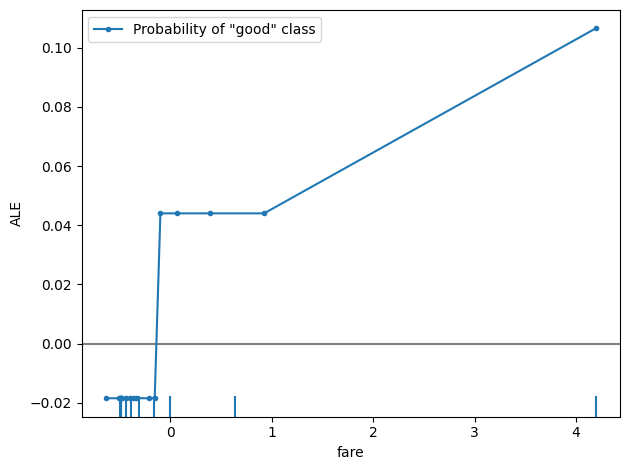

In [ ]:
#Accumulated Local Effects- How does model prediction vary with respect to features of interest?
#INFO: It works on numerical featues
# Gives ALE for different numerical features
# ALE should be wrt to a class good/bad 
#TODO: change the pred() funtion to give output wrt to a specific
from alibi.explainers import ALE, plot_ale

def pred(x):
    predictions = dense_model.predict(x)
    final_predictions = (predictions > 0.5).astype(int)
    return final_predictions

# Model is a binary classifier so we only take the first model output corresponding to "good" class probability.
output = preprocessing_model.predict(x_test.to_numpy().tolist())
ale = ALE(pred, feature_names=x_test.columns)
exp = ale.explain(output)

plot_ale(exp, features=['fare'], line_kw={'label': 'Probability of "good" class'})

In [ ]:
exp

Explanation(meta={
  'name': 'ALE',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'check_feature_resolution': True,
              'low_resolution_threshold': 10,
              'extrapolate_constant': True,
              'extrapolate_constant_perc': 10.0,
              'extrapolate_constant_min': 0.1,
              'min_bin_points': 4}
            ,
  'version': '0.9.5dev'}
, data={
  'ale_values': [array([[-0.3844697],
       [ 0.3844697]]), array([[ 0.09030032],
       [ 0.09030032],
       [ 0.09030032],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [ 0.01887175],
       [-0.10612825],
       [-0.19703734],
       [-0.19703734],
       [-0.19703734]]), array([[ 0.07503444],
       [-0

In [ ]:
anchor_pred(X_train.iloc[1,:].to_numpy().tolist())

1/1 [==============================] - 0s 37ms/step


array([[1]])

In [ ]:
X_train.iloc[1,:].to_numpy().tolist()

['female', 38.0, 1, 0, 71.2833, 'First', 'C', 'Cherbourg', 'n']

In [ ]:
list(X_train.columns)

['sex',
 'age',
 'n_siblings_spouses',
 'parch',
 'fare',
 'class',
 'deck',
 'embark_town',
 'alone']

In [ ]:
def anchor_pred(x):
    print(x)
    predictions = dense_model.predict(x)
    final_predictions = (predictions > 0.5).astype(int)
    return final_predictions

In [ ]:
from alibi.explainers import AnchorTabular

predict_fn = anchor_pred
explainer = AnchorTabular(predict_fn, list(X_train.columns))
explainer.fit(output)

# x is the instance to explain
result = explainer.explain(output)

print('Anchor =', result.data['anchor'])
print('Coverage = ', result.data['coverage'])

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 45ms/step
[[-0.7275079   0.42943236 -0.5136258  -0.48401728 -0.48273844 -0.82992667
  -0.45484465 -0.57665044 -0.8279398 ]]
1/1 [==============================] - 0s 37ms/step
[[ 1.3745551e+00  7.4938542e-01  4.7423756e-01  8.0190986e-01
   1.4022372e+00  4.3003452e-01  2.7082357e-01  9.8179793e-01
   1.2078174e+00]
 [ 1.3745551e+00  7.4938542e-01  4.7423756e-01 -4.8401728e-01
   3.9437130e-01  4.3003452e-01  1.7221600e+00 -5.7665044e-01
   1.2078174e+00]
 [-7.2750789e-01 -7.7039152e-01 -5.1362580e-01 -4.8401728e-01
  -5.5674738e-01 -8.2992667e-01 -4.5484465e-01  9.8179793e-01
  -8.2793981e-01]
 [-7.2750789e-01  2.9491063e-02 -5.1362580e-01 -4.8401728e-01
  -4.5615935e-01 -8.2992667e-01 -4.5484465e-01 -5.7665044e-01
  -8.2793981e-01]
 [ 1.3745551e+00 -6.9040328e-01  4.7423756e-01 -4.8401728e-01
  -4.5020196e-01 -8.2992667e-01 -4.5484465e-01 -5.7665044e-01
   1.2078174e+00]
 [ 1.3745551e+00 -1.3048546e-01 -5.136258

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
for layer in model.layers:
    print(layer)
    if hasattr(layer, 'weights'):
        weights = layer.get_weights()  # Returns a list of numpy arrays
        print(f"Weights of {layer.name}:")
        for weight_array in weights:
            k = weight_array
            print(weight_array.shape)
            print(weight_array)

Weights of input_1:
Weights of multi_category_encoding:
(2,)
[b'male' b'female']
(7,)
[b'0' b'1' b'2' b'4' b'3' b'8' b'5']
(6,)
[b'0' b'1' b'2' b'5' b'4' b'3']
(3,)
[b'Third' b'First' b'Second']
(8,)
[b'unknown' b'C' b'B' b'E' b'D' b'A' b'F' b'G']
(4,)
[b'Southampton' b'Cherbourg' b'Queenstown' b'unknown']
(2,)
[b'y' b'n']
Weights of normalization:
(9,)
[ 1.3460923 29.631308   1.5199361  1.3763956 34.3854     1.6586922
  1.6267942  1.3700157  1.4066987]
(9,)
[2.2631252e-01 1.5629588e+02 1.0247223e+00 6.0473800e-01 2.9761584e+03
 6.2992042e-01 1.8989949e+00 4.1173252e-01 2.4129483e-01]
()
627
Weights of dense:
(9, 32)
[[ 1.0576434  -0.35929665 -1.2357174   0.47566906 -0.02816359  2.6433935
  -0.14225444 -0.33795315  1.1293479   2.089843   -0.5029013  -1.3011488
   1.4498525  -0.7511772   0.4753492   0.30278692 -0.636578    0.730574
  -0.68008864  1.0636848  -0.51590735  0.05025548 -0.28250653  1.4780889
   0.21208972  0.2892703   0.6289771   0.7288685  -0.38018528  0.4639636
   0.016160

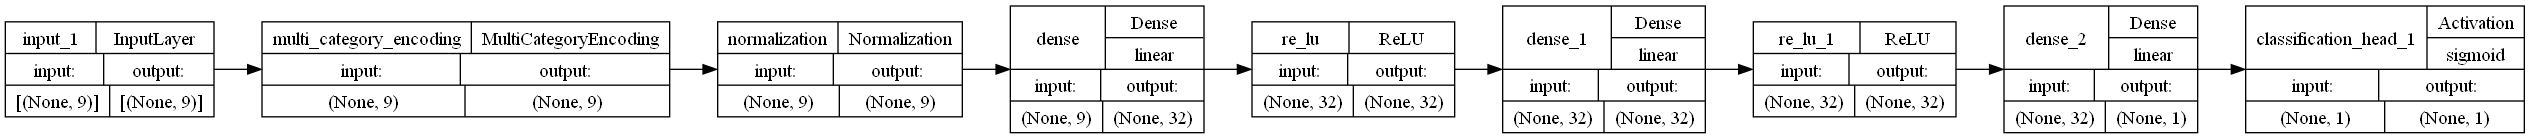

In [ ]:
from keras.utils import vis_utils
vis_utils.plot_model(model, to_file='test_model.png', show_shapes=True, show_layer_names=True,rankdir='LR', expand_nested=True, show_layer_activations=True )

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

import autokeras as ak


In [ ]:
house_dataset = fetch_california_housing()
df = pd.DataFrame(
    np.concatenate(
        (house_dataset.data, house_dataset.target.reshape(-1, 1)), axis=1
    ),
    columns=house_dataset.feature_names + ["Price"],
)
train_size = int(df.shape[0] * 0.9)
df[:train_size].to_csv("train.csv", index=False)
df[train_size:].to_csv("eval.csv", index=False)
train_file_path = "train.csv"
test_file_path = "eval.csv"


In [ ]:
# Initialize the structured data regressor.
reg = ak.StructuredDataRegressor(
    overwrite=True, max_trials=3
)  # It tries 3 different models.
# Feed the structured data regressor with training data.
reg.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "Price",
    epochs=100,
)
# Predict with the best model.
predicted_y = reg.predict(test_file_path)
# Evaluate the best model with testing data.
print(reg.evaluate(test_file_path, "Price"))


Trial 3 Complete [00h 00m 40s]
val_loss: 0.8961352705955505

Best val_loss So Far: 0.8961352705955505
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
581/581 [==============================] - 2s 2ms/step - loss: 4.9231 - mean_squared_error: 4.9231
Epoch 2/100
581/581 [==============================] - 2s 3ms/step - loss: 1.9850 - mean_squared_error: 1.9850
Epoch 3/100
581/581 [==============================] - 1s 2ms/step - loss: 0.9098 - mean_squared_error: 0.9098
Epoch 4/100
581/581 [==============================] - 1s 3ms/step - loss: 0.7267 - mean_squared_error: 0.7267
Epoch 5/100
581/581 [==============================] - 1s 2ms/step - loss: 0.6274 - mean_squared_error: 0.6274
Epoch 6/100
581/581 [==============================] - 1s 3ms/step - loss: 0.5718 - mean_squared_error: 0.5718
Epoch 7/100
581/581 [==============================] - 1s 2ms/step - loss: 0.5442 - mean_squared_error: 0.5442
Epoch 8/100
581/581 [==============================

INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


65/65 [==============================] - 0s 2ms/step - loss: 0.3505 - mean_squared_error: 0.3505
[0.3504956066608429, 0.3504956066608429]


In [ ]:
reg_model = reg.export_model()

In [ ]:
reg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 8)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)


(60000, 28, 28)
(60000,)
[5 0 4]


In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)


# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))


Trial 1 Complete [00h 16m 21s]
val_loss: 0.03539927676320076

Best val_loss So Far: 0.03539927676320076
Total elapsed time: 00h 16m 21s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
1875/1875 [==============================] - 103s 54ms/step - loss: 0.1650 - accuracy: 0.9503
Epoch 2/10
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0755 - accuracy: 0.9767
Epoch 3/10
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0617 - accuracy: 0.9810
Epoch 4/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0538 - accuracy: 0.9829
Epoch 5/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0463 - accuracy: 0.9853
Epoch 6/10
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0396 - accuracy: 0.9868
Epoch 7/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0388 - accuracy: 0.9871
Epoch 8/10
1875/1875 [==============================] - 106s 56ms/step - loss: 0.0343 - accuracy: 0.9885
Epoch 9/10
1875/1875 [==============================] - 108s 58ms/step - loss: 0.0327 - accuracy: 0.9895
Epoch 10/10
1875/1875 [==============================] 

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


313/313 [==============================] - 4s 13ms/step
[['7']
 ['2']
 ['1']
 ...
 ['4']
 ['5']
 ['6']]
313/313 [==============================] - 4s 13ms/step - loss: 0.0391 - accuracy: 0.9878
[0.03907911479473114, 0.9878000020980835]


In [ ]:
# INPUT NODES
'''ImageInput
    Input
    StructuredDataInput
    TextInput'''

# Types of block
'''ConvBlock
    DenseBlock
    Embedding
    Merge
    ResNetBlock
    RNNBlock
    SpatialReduction
    TemporalReduction
    XceptionBlock
    ImageBlock
    StructuredDataBlock
    TextBlock
    ImageAugmentation
    Normalization
    TextToIntSequence
    TextToNgramVector
    CategoricalToNumerical
    ClassificationHead
    RegressionHead'''

# Utilities
'''
    image_dataset_from_directory
    text_dataset_from_directory
'''

In [ ]:
import json

# Open the JSON file for reading
with open('D:\\Courses\\Master_Thesis\\automl_exp\\MT_Code\\structured_data_classifier\\trial_0\\trial_mid1695578881179.json', 'r') as file:
    # Use json.load() to parse the JSON data
    data = json.load(file)

# Now, 'data' contains the parsed JSON data as a Python dictionary or list


In [ ]:
data

{'trial_id': '0',
 'hyperparameters': {'space': [{'class_name': 'Boolean',
    'config': {'name': 'structured_data_block_1/normalize',
     'default': False,
     'conditions': []}},
   {'class_name': 'Boolean',
    'config': {'name': 'structured_data_block_1/dense_block_1/use_batchnorm',
     'default': False,
     'conditions': []}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/num_layers',
     'default': 2,
     'conditions': [],
     'values': [1, 2, 3],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/units_0',
     'default': 32,
     'conditions': [],
     'values': [16, 32, 64, 128, 256, 512, 1024],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name': 'structured_data_block_1/dense_block_1/dropout',
     'default': 0.0,
     'conditions': [],
     'values': [0.0, 0.25, 0.5],
     'ordered': True}},
   {'class_name': 'Choice',
    'config': {'name'